# TREINO COM FLATTEN E DATASET IMAGEM 64x64x3 V2 HOLDOUT CALLBACKS

In [1]:
#Import libraries
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling, BatchNormalization
from keras.callbacks import ModelCheckpoint
from numpy import load
from tensorboard import version

import os, datetime
import numpy as np
from keras.preprocessing import image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold

import sklearn.datasets
import gc

In [2]:
#Import and check tensorflow version
import tensorflow as tf
print(tf.__version__)

#check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print("tensorboard.version.VERSION: ", version.VERSION)

2.10.1
Num GPUs Available:  0
Num GPUs Available:  0
tensorboard.version.VERSION:  2.10.1


In [3]:
directory='../Images/80x80'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    label_mode='int',
    seed=1337,
    image_size=(80,80),
    batch_size= None,
)

Found 16621 files belonging to 5 classes.


In [4]:
image_array = []
label_array = []

for element in train_ds:  
    
    image_array.append(np.asarray(element[0]))
    label_array.append(np.asarray(element[1]))

image_array = np.asarray(image_array)
label_array = np.asarray(label_array)

print(image_array.shape)
print(label_array.shape)

(16621, 80, 80, 3)
(16621,)


## TRAIN MODEL AND COMPARE WITH MODEL FOLD6

In [5]:
model_x_train, model_x_val, model_y_train, model_y_val = train_test_split(image_array, label_array,
                                                                          test_size=0.3, random_state=42)

model_x_val, model_x_test, model_y_val, model_y_test = train_test_split(model_x_val, model_y_val, test_size=0.5)

print('Data for training:')
print(model_x_train.shape)
print(model_y_train.shape)

print('Data for validation:')
print(model_x_val.shape)
print(model_y_val.shape)

print('Data for testing:')
print(model_x_test.shape)
print(model_y_test.shape)

Data for training:
(11634, 80, 80, 3)
(11634,)
Data for validation:
(2493, 80, 80, 3)
(2493,)
Data for testing:
(2494, 80, 80, 3)
(2494,)


In [7]:
gc.collect()

model = Sequential()
##normalizaçao [-1,1]
model.add(Rescaling(1./127.5, offset=-1, input_shape=(80, 80, 3)))
model.add(Flatten())
model.add(Dense(1350, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.85))
model.add(Dense(500, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.7))
model.add(Dense(5,activation='softmax'))

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

#Saved models path
model_name = 'flatten_holdout_80x80'
save_path_best_model_holdout = '../Models/Holdout/Flatten_80x80/' + model_name + '.hdf5'

checkpoint_val_acc = tf.keras.callbacks.ModelCheckpoint(save_path_best_model_holdout, 
                                                monitor='val_accuracy', verbose=0, 
                                                save_best_only=True, mode='max')

callbacks_list = [checkpoint_val_acc]

# Fit data to model - uses x_train to train and validate
model_history = model.fit(model_x_train,model_y_train,validation_data=(model_x_val,model_y_val), 
                          verbose=2, batch_size=128,callbacks=callbacks_list, epochs=50)

#Frees space in GPU memory
#gc.collect()

#load best model from fold
best_model_holdout = load_model(save_path_best_model_holdout)

# Generate generalization metrics - uses x_test to validate and predict
model_scores = best_model_holdout.evaluate(model_x_val,model_y_val, verbose=0)

# Calculate predicted labels for the test set
model_y_pred = np.argmax(best_model_holdout.predict(model_x_test), axis=-1)

# Calculate precision, recall, and F1 score
model_accuracy = accuracy_score(model_y_test, model_y_pred)
model_precision = precision_score(model_y_test, model_y_pred, average='macro')
model_recall = recall_score(model_y_test, model_y_pred, average='macro')
model_f1 = f1_score(model_y_test, model_y_pred, average='macro')
model_cm = confusion_matrix(model_y_test, model_y_pred)

Epoch 1/50
91/91 - 5s - loss: 1.0840 - accuracy: 0.6880 - val_loss: 2.6547 - val_accuracy: 0.5692 - 5s/epoch - 57ms/step
Epoch 2/50
91/91 - 5s - loss: 0.6280 - accuracy: 0.7945 - val_loss: 0.5297 - val_accuracy: 0.8303 - 5s/epoch - 53ms/step
Epoch 3/50
91/91 - 5s - loss: 0.5317 - accuracy: 0.8296 - val_loss: 0.3268 - val_accuracy: 0.8933 - 5s/epoch - 53ms/step
Epoch 4/50
91/91 - 5s - loss: 0.4565 - accuracy: 0.8535 - val_loss: 0.3016 - val_accuracy: 0.8997 - 5s/epoch - 54ms/step
Epoch 5/50
91/91 - 5s - loss: 0.4151 - accuracy: 0.8675 - val_loss: 0.3026 - val_accuracy: 0.9053 - 5s/epoch - 53ms/step
Epoch 6/50
91/91 - 5s - loss: 0.3748 - accuracy: 0.8797 - val_loss: 0.2882 - val_accuracy: 0.9114 - 5s/epoch - 54ms/step
Epoch 7/50
91/91 - 5s - loss: 0.3390 - accuracy: 0.8912 - val_loss: 0.2877 - val_accuracy: 0.9105 - 5s/epoch - 50ms/step
Epoch 8/50
91/91 - 5s - loss: 0.3171 - accuracy: 0.8950 - val_loss: 0.2614 - val_accuracy: 0.9146 - 5s/epoch - 54ms/step
Epoch 9/50
91/91 - 5s - loss: 0.

In [8]:
print('\n----------------------------------------------------------')
print(f'Score: Eval {model.metrics_names[0]} of {round(model_scores[0],5)}; Eval {model.metrics_names[1]} of {round(model_scores[1]*100,5)}%')
print(f'> Accuracy: {round(model_accuracy*100,5)}%')
print(f'> Precision: {round(model_precision*100,5)}%')
print(f'> Recall: {round(model_recall*100,5)}%')
print(f'> F1 Score: {round(model_f1*100,5)}%')


----------------------------------------------------------
Score: Eval loss of 0.28991; Eval accuracy of 93.14079%
> Accuracy: 92.38172%
> Precision: 90.23226%
> Recall: 91.17025%
> F1 Score: 90.55282%


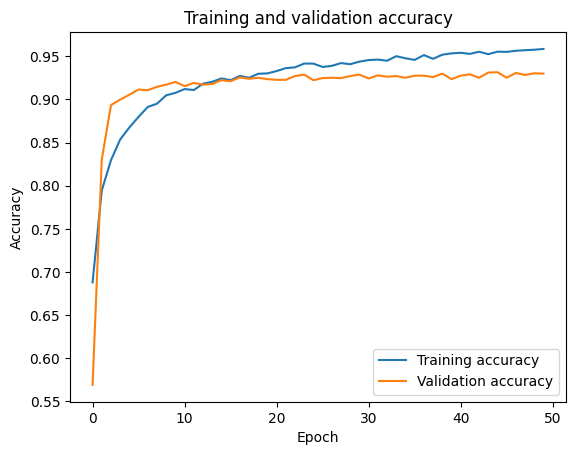

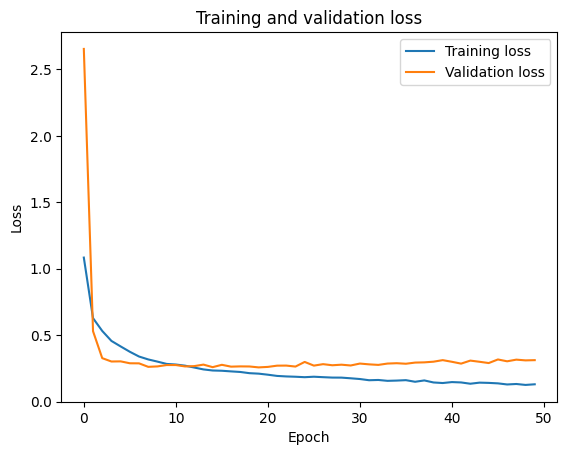

In [9]:
train_acc = model_history.history['accuracy']
train_loss = model_history.history['loss']
val_acc = model_history.history['val_accuracy']
val_loss = model_history.history['val_loss']

#plot accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#plot loss
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix for Model')

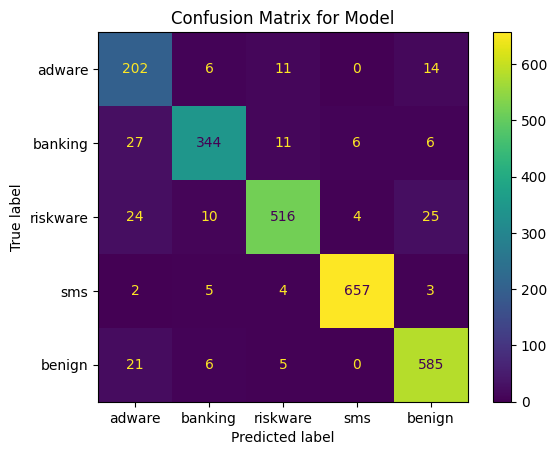

In [10]:
#classes: 0 - adware, 1 - banking, 2 - riskware, 3 - sms, 4 - benign
classes = ['adware',  'banking', 'riskware', 'sms', 'benign']

model_cm_display = ConfusionMatrixDisplay(model_cm,display_labels=classes)
model_cm_display.plot()
model_cm_display.ax_.set_title(f'Confusion Matrix for Model')